In [121]:
import numpy as np
from numpy import mean,std, dstack
import pandas as pd
from pandas import read_csv

import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils import to_categorical

In [122]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    feature_name_df = pd.read_csv('./data/HAR/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    

    X_train = pd.read_csv('./data/HAR/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/HAR/test/X_test.txt',sep='\s+', names=feature_name)
    

    y_train = pd.read_csv('./data/HAR/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/HAR/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    return X_train, X_test, y_train, y_test

In [123]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [125]:
X_train.shape

(7352, 561)

In [126]:
batch_size = 64
validation_split = 0.2

In [127]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences):
            break

        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [128]:
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

X_train, y_train = split_sequences(train_set, 30)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 30)
print(X_test.shape, y_test.shape)

(7323, 30, 561) (7323,)
(2918, 30, 561) (2918,)


In [129]:
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(7323, 7)
(2918, 7)


In [130]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [131]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [132]:
train_epochs = 20
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 5s 42ms/step - loss: 0.7793 - accuracy: 0.6905 - val_loss: 0.4126 - val_accuracy: 0.8478
Epoch 2/20
92/92 [==============================] - 3s 35ms/step - loss: 0.3209 - accuracy: 0.8735 - val_loss: 0.4112 - val_accuracy: 0.8546
Epoch 3/20
92/92 [==============================] - 3s 35ms/step - loss: 0.2399 - accuracy: 0.9146 - val_loss: 0.2123 - val_accuracy: 0.9208
Epoch 4/20
92/92 [==============================] - 3s 35ms/step - loss: 0.1586 - accuracy: 0.9413 - val_loss: 0.1728 - val_accuracy: 0.9509
Epoch 5/20
92/92 [==============================] - 3s 36ms/step - loss: 0.1315 - accuracy: 0.9548 - val_loss: 0.1605 - val_accuracy: 0.9365
Epoch 6/20
92/92 [==============================] - 3s 36ms/step - loss: 0.1099 - accuracy: 0.9633 - val_loss: 0.1716 - val_accuracy: 0.9283
Epoch 7/20
92/92 [==============================] - 3s 37ms/step - loss: 0.0838 - accuracy: 0.9712 - val_loss: 0.2594 - val_accuracy: 0.9092
Epoch 8/20
92

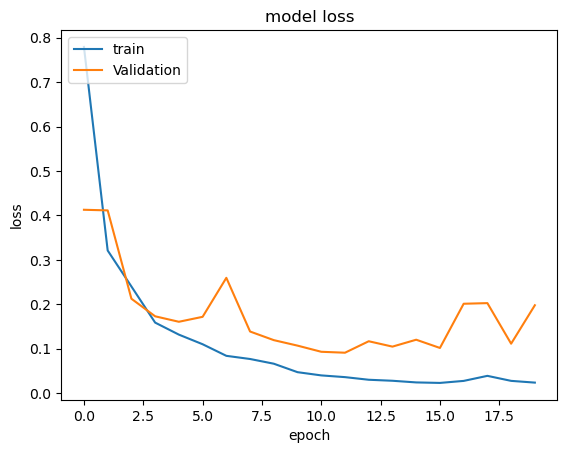

In [133]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [134]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions = model.predict(X_test)

Accuracy of the CNN model 0.9557916522026062
92/92 [==============================] - 1s 9ms/step


In [135]:
predictions

array([[1.8322245e-09, 5.0614823e-09, 3.1023009e-09, ..., 1.0297792e-02,
        9.8970211e-01, 1.3575749e-08],
       [1.3251336e-09, 3.5587764e-09, 1.6789673e-09, ..., 6.7190160e-03,
        9.9328095e-01, 1.0802627e-08],
       [7.4312179e-09, 1.9291186e-08, 1.2203333e-08, ..., 5.0041400e-02,
        9.4995815e-01, 2.5728940e-07],
       ...,
       [2.0616532e-03, 1.9256383e-03, 8.9581215e-01, ..., 2.7961363e-03,
        4.3138519e-02, 3.5362558e-03],
       [1.9028585e-03, 2.1314663e-03, 8.9527553e-01, ..., 2.6894072e-03,
        3.9995823e-02, 3.8041479e-03],
       [2.5313555e-03, 2.8058884e-03, 8.3076769e-01, ..., 2.0450803e-03,
        3.4698222e-02, 4.3632621e-03]], dtype=float32)

In [136]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[478   0  11   7   0   0]
 [  0 454  16   0   1   0]
 [  3   2 415   0   0   0]
 [  0   0   0 437  54   0]
 [  0   2   0   7 494   0]
 [  0   0   0  19   7 511]]
**** Classification Report ****
              precision    recall  f1-score   support

     Walking       0.99      0.96      0.98       496
      Walkup       0.99      0.96      0.98       471
    Walkdown       0.94      0.99      0.96       420
     Sitting       0.93      0.89      0.91       491
    Standing       0.89      0.98      0.93       503
      Laying       1.00      0.95      0.98       537

    accuracy                           0.96      2918
   macro avg       0.96      0.96      0.96      2918
weighted avg       0.96      0.96      0.96      2918



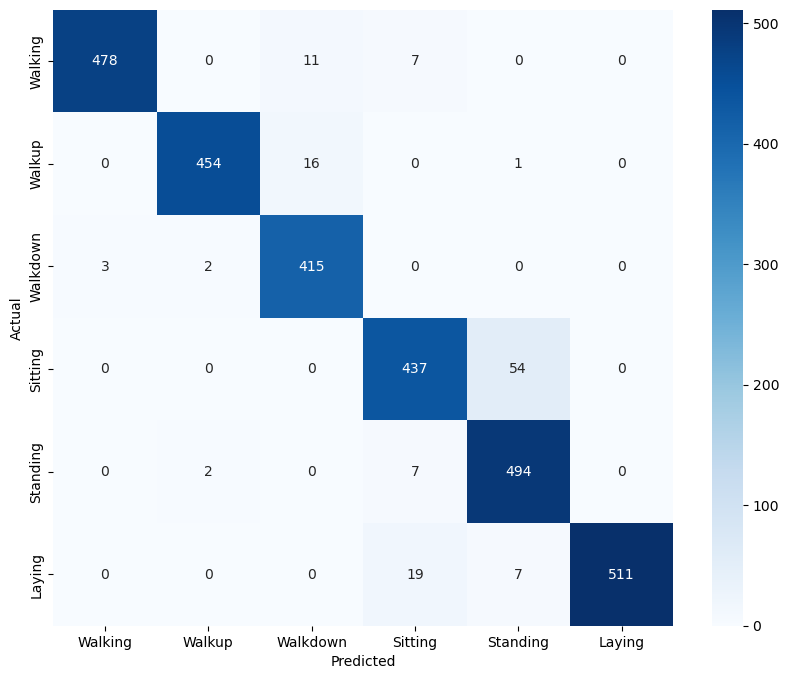

In [137]:
import seaborn as sns

classNames=["Walking","Walkup","Walkdown","Sitting","Standing","Laying"]
display_results(y_test,predictions,classNames)